This notebook is an example of calculating Emrpirical Risk Bounds on a real dataset.
The dataset was sourced from here: https://www.kaggle.com/primaryobjects/voicegender

### Step 1: imports and loading data

In [1]:
# import sltlib module from parallel folder

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sltlib import rademacher, outlier
from sltlib.utils import *
from sltlib.basefuncs import *

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Plotting lib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def data_prep(data):
    data_size = len(data.index)

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # code categories to -1/1
    gender_encoder = LabelEncoder()
    y = np.array(gender_encoder.fit_transform(y))
    y = y * 2 - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(X)
    X = np.array(scaler.transform(X))

    return X, y

In [4]:
from sklearn import svm
from sklearn.model_selection import train_test_split
voice_shuffle = load_file('voice_shuffled')

In [5]:
voice_shuffle.shape

(3168, 21)

In [6]:
X_full, y_full = data_prep(voice_shuffle)

# Cut down to 10 features
X_full = X_full[:,:10]

# Add intercept as a feature
X_extended = np.ones((X_full.shape[0],X_full.shape[1] + 1))
X_extended[:,:-1] = X_full

# Use 100 points for training
X, X_test, y, y_test = train_test_split(X_extended, y_full, train_size=100, random_state=45)

In [7]:
X.shape

(100, 11)

### step 2: get normal SVM models

In [8]:
mname = "voice_models"

In [9]:
# generate models

C_vals = np.logspace(-2, 4, 15)
models = list()

for index, cval in enumerate(C_vals):
    print(index,end='/')
    models.append(svm.LinearSVC(loss='hinge', dual=True, C=cval, fit_intercept=False, random_state=42, max_iter=1e7))
    models[index].fit(X, y)

0/1/2/3/4/5/6/7/8/9/10/11/12/13/14/

In [27]:
save_file(mname,models)

In [10]:
# Load models from file
C_vals = np.logspace(-2, 4, 15)
models = load_file(mname)

In [11]:
msizes=[]
bounds=[]
risks=[]
emp_risks=[]
for model in models:
    w = np.array(model.coef_[0])
    margin_size = 1 / np.sqrt(np.sum(w ** 2))
    
    C = model.get_params()['C']
    emp_risk = (y != model.predict(X)).sum()/X.shape[0]
    risk = (y_test != model.predict(X_test)).sum()/X_test.shape[0]
    
    risks.append(risk)
    emp_risks.append(emp_risk)
    
    print(C, margin_size, model.intercept_, emp_risk, risk, sep='\t')
    msizes.append(margin_size)
    bounds.append(np.abs(model.intercept_))

0.01	2.054689309843012	0.0	0.24	0.27477183833116037
0.02682695795279726	1.1521239229836053	0.0	0.14	0.1636245110821382
0.07196856730011521	0.7429971832735864	0.0	0.13	0.1424380704041721
0.19306977288832497	0.5085355423085413	0.0	0.12	0.12972620599739243
0.517947467923121	0.39593881417341376	0.0	0.08	0.1059322033898305
1.3894954943731375	0.3185774926273573	0.0	0.07	0.09941329856584094
3.727593720314938	0.27384738537082287	0.0	0.07	0.09810951760104303
10.0	0.24026233737443922	0.0	0.08	0.09941329856584094
26.826957952797247	0.1990602101436239	0.0	0.08	0.10039113428943937
71.96856730011514	0.14349622966023895	0.0	0.08	0.10104302477183832
193.06977288832496	0.13100894839995675	0.0	0.09	0.10332464146023468
517.9474679231213	0.08412669803568178	0.0	0.09	0.10658409387222946
1389.4954943731361	0.08403933100531108	0.0	0.09	0.10658409387222946
3727.593720314938	0.08403721382454483	0.0	0.09	0.10658409387222946
10000.0	0.08228188103090901	0.0	0.1	0.10528031290743155


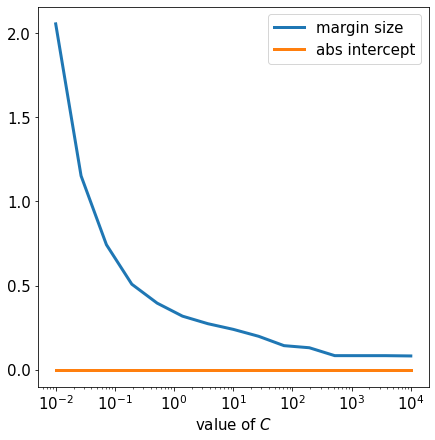

In [12]:
plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
plt.xscale('log')
plt.xlabel(r'value of $C$')

plt.plot(C_vals, msizes, label="margin size", lw=3)
plt.plot(C_vals, bounds, label="abs intercept", lw=3)
plt.legend()

plt.show()

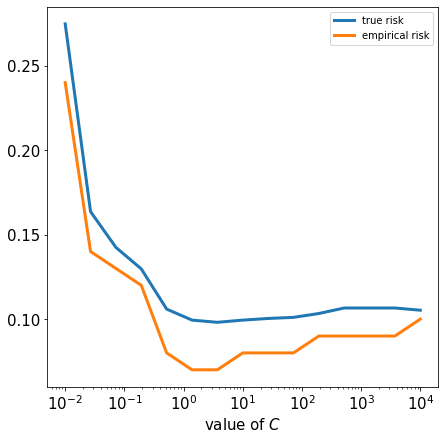

In [13]:
plt.figure(figsize=(7,7))
plt.xscale('log')
plt.xlabel(r'value of $C$')

plt.plot(C_vals, risks, label="true risk", lw=3)
plt.plot(C_vals, emp_risks, label="empirical risk", lw=3)
plt.legend(fontsize=10)

### step 3: calc rademacher complexities and outlier function

In [14]:
# We will be saving our progress in histories/voice

folder_name = "voice"

In [16]:
runs_per_sample = 1
maxiter = 200
init_temp = 5500
accept = -5

pump_cycles = 100

m = X.shape[0]

In [17]:
Mlc = rademacher.LML(X=X_extended,
          Y=y_full,
          path=None,    # set path manually later
          margin=None,  # set margin manually later
          sample_size = m,
          solver_args={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept},
          balanced=True)

Lin = rademacher.Linear(X=X_extended, Y=y_full,
            path=None,    # set path manually later
            sample_size = m,
            balanced=True)

Out = outlier.LML(X=X_extended, Y=y_full,
                path=None,    # set path manually later
                margin=None,  # set margin manually later
                solver_args={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept},
                sample_size = m)


The following block of code will sample each of the three constants *pump_cycles* number of times. All progress is saved, so its ok to interrupt and relaunch this block. If no history cache is present, it will write "Failed to load history" and create new cache files in histories/voice/.

In [18]:
for pc in range(pump_cycles):

    for index, model in enumerate(models):
        
        print('\n', index, ':', pc, '///', end=' ')
        
        # get margin size
        
        w = np.array(model.coef_[0])
        mar = 1 / np.sqrt(np.sum(w ** 2))
        
        # sample X and Y sets of size m from the whole set
        Mlc._sample_set()
        Pump_X = Mlc.X
        Pump_Y = Mlc.Y

        radvecRR = Mlc._gen_radvec()
        
        #################
        ## Calculate Confidence Rademacher Complexity        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Rconfidence_NEW'
        
        Lin.path = DATA_SAVE_NAME
        Lin.radvec = radvecRR
        Lin.X = Pump_X
        Lin.Y = Pump_Y
        
        Lin.load()
        Lin.calc(verbose=True, resample=False)
        Lin.save()

        #################
        ## Calculate Margin loss Rademacher Complexity        
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Rmarginloss_NEW'
        
        Mlc.path = DATA_SAVE_NAME
        Mlc.margin = mar
        Mlc.radvec = radvecRR
        Mlc.X = Pump_X
        Mlc.Y = Pump_Y
        
        Mlc.load()
        Mlc.calc(radvec=radvecRR, verbose=True, resample=False)
        Mlc.save()

        #################
        ## Calculate Outlier Func
        DATA_SAVE_NAME = 'histories/'+folder_name+'/'+str(index)+'_Outlier_NEW'
        
        Out.path = DATA_SAVE_NAME
        Out.margin = mar
        Out.X = Pump_X
        Out.Y = Pump_Y
        
        Out.load()
        Out.calc(verbose=True, resample=False)
        Out.save()
 


 0 : 0 /// LIN::14.775092054132834
LML::9.630860201013219
LML::0.09328296073182452

 1 : 0 /// LIN::12.82515950105711
LML::6.73998279816751
LML::0.044066014141034615

 2 : 0 /// LIN::8.00859480546053
LML::5.639790390870749
LML::0.056657685468028185

 3 : 0 /// LIN::8.494853939498709
LML::13.414646760757822
LML::0.06177254089557416

 4 : 0 /// LIN::8.895287548539981
LML::9.443485382797144
LML::0.08609235607750676

 5 : 0 /// LIN::5.2793176438494775
LML::7.705760848875087
LML::0.08733261723976193

 6 : 0 /// LIN::3.057054449927606
LML::12.651982346043715
LML::0.0933535235583921

 7 : 0 /// LIN::2.9637502929868234
LML::9.834049575834118
LML::0.12879594088275442

 8 : 0 /// LIN::4.764617645109727
LML::13.736017641857844
LML::0.1270192552668219

 9 : 0 /// LIN::9.352067533924304
LML::18.999642410016854
LML::0.146468680170179

 10 : 0 /// LIN::8.517778811830741
LML::14.712270140698706
LML::0.20092568789409232

 11 : 0 /// LIN::7.440394532559137
LML::12.590043970057497
LML::0.136149666686615

LML::0.09981908186075894

 8 : 6 /// LIN::7.134592907521233
LML::12.48223965431881
LML::0.09501916732107107

 9 : 6 /// LIN::5.514001546370834
LML::11.432866505290882
LML::0.11377510810003688

 10 : 6 /// LIN::7.893488379027581
LML::13.883077724052557
LML::0.13661885813551872

 11 : 6 /// LIN::6.536208565938365
LML::12.43552438771336
LML::0.11733713508302587

 12 : 6 /// LIN::8.520498435032149
LML::14.919096920278594
LML::0.12873935554767146

 13 : 6 /// LIN::8.56160612211998
LML::14.412273437448853
LML::0.16912133981963273

 14 : 6 /// LIN::7.495993389765861
LML::13.415976200662369
LML::0.10862178188910088

 0 : 7 /// LIN::3.7613990940874236
LML::4.946696357320827
LML::0.03579845923053104

 1 : 7 /// LIN::15.074971279150029
LML::6.360773719945993
LML::0.04459955880255417

 2 : 7 /// LIN::9.995881863305586
LML::14.9720864113337
LML::0.06425636206194985

 3 : 7 /// LIN::6.2347233129951
LML::6.28293122403907
LML::0.11535177484613013

 4 : 7 /// LIN::7.042853007201905
LML::10.177874843792

LML::3.858040161213183
LML::0.05294704709365328

 1 : 13 /// LIN::7.533953401115802
LML::11.37626214323933
LML::0.06305333651484946

 2 : 13 /// LIN::7.871200336865571
LML::10.936034710783376
LML::0.11382419215522632

 3 : 13 /// LIN::12.503858044969837
LML::8.136542341890209
LML::0.06640749553606717

 4 : 13 /// LIN::12.190227084074122
LML::9.098275037884093
LML::0.10388604283491609

 5 : 13 /// LIN::5.888939748832429
LML::11.558660424080317
LML::0.10418546703918585

 6 : 13 /// LIN::12.973053739727673
LML::9.263506965346213
LML::0.09280522422670312

 7 : 13 /// LIN::7.517184331446664
LML::9.160832588751356
LML::0.08340742292337494

 8 : 13 /// LIN::10.594183774326316
LML::14.543475163146635
LML::0.15299828039539404

 9 : 13 /// LIN::10.265915291159917
LML::15.144964334160463
LML::0.21638196106293694

 10 : 13 /// LIN::6.741058354933292
LML::12.254382353087314
LML::0.12166927743454203

 11 : 13 /// LIN::14.191463654553809
LML::13.944506251403267
LML::0.11749226648399669

 12 : 13 /// 

LML::9.69233072283007
LML::0.14234076664025097

 8 : 19 /// LIN::2.631353519584086
LML::15.225613984371627
LML::0.08440622631497297

 9 : 19 /// LIN::16.706934284666726
LML::14.691420194762422
LML::0.13542514331751232

 10 : 19 /// LIN::6.007457642271144
LML::19.631482726007423
LML::0.11139608154966715

 11 : 19 /// LIN::5.33317272208552
LML::12.237977882628446
LML::0.13831826974896233

 12 : 19 /// LIN::11.59479220141344
LML::15.46994958590615
LML::0.16295741507759515

 13 : 19 /// LIN::7.846669739489888
LML::14.267857844531193
LML::0.14932788130579544

 14 : 19 /// LIN::5.102053030571001
LML::12.754447518275823
LML::0.11935215315326694

 0 : 20 /// LIN::10.311076016666757
LML::3.454220764182806
LML::0.04678961873347698

 1 : 20 /// LIN::8.218916840124558
LML::5.463571894625117
LML::0.0524160515189801

 2 : 20 /// LIN::10.326767777020201
LML::6.7782761632304895
LML::0.055844146528442384

 3 : 20 /// LIN::10.054748909431895
LML::7.857653005042281
LML::0.10092581016347668

 4 : 20 /// L

LML::18.746530455528415
LML::0.20467360948186777

 0 : 26 /// LIN::6.937634545467492
LML::7.723493412130411
LML::0.059613116082341766

 1 : 26 /// LIN::5.798117744305528
LML::3.5813654804758075
LML::0.06256914235411326

 2 : 26 /// LIN::15.153912210304057
LML::9.404102597054404
LML::0.08525522845527533

 3 : 26 /// LIN::4.967217563972134
LML::11.55338625466891
LML::0.09376893451271961

 4 : 26 /// LIN::6.67264044180743
LML::13.094114014294359
LML::0.16058888610772337

 5 : 26 /// LIN::10.471468900474568
LML::9.594707538320462
LML::0.12243585292472053

 6 : 26 /// LIN::5.262995218613753
LML::13.52441226023794
LML::0.09080195218989917

 7 : 26 /// LIN::6.8294078400382086
LML::12.39084683416774
LML::0.1212873779939051

 8 : 26 /// LIN::8.855007277075206
LML::13.50347746831514
LML::0.14056758725776303

 9 : 26 /// LIN::8.408701990886884
LML::7.54020816382495
LML::0.14393658098227063

 10 : 26 /// LIN::16.421783521597806
LML::12.356437209428329
LML::0.1291999250657062

 11 : 26 /// LIN::15.

LML::12.215769312297764
LML::0.13501806757282214

 7 : 32 /// LIN::5.633341706393123
LML::6.998684570320206
LML::0.09156196318988208

 8 : 32 /// LIN::4.5402485960545125
LML::10.933021223382735
LML::0.14417919611217755

 9 : 32 /// LIN::5.7701241908313925
LML::14.706538979914168
LML::0.11711394371152928

 10 : 32 /// LIN::4.348297624212928
LML::10.43440033011159
LML::0.2119907669293778

 11 : 32 /// LIN::13.050997771304457
LML::17.254400007429265
LML::0.1252567231736445

 12 : 32 /// LIN::8.71983648037395
LML::12.551477963448372
LML::0.10307641098067755

 13 : 32 /// LIN::7.935752091518352
LML::13.92770071598159
LML::0.12805214015311459

 14 : 32 /// LIN::4.171370613485782
LML::12.236032396336913
LML::0.1432639952797905

 0 : 33 /// LIN::11.7528497163309
LML::3.3592236001317017
LML::0.1442153845767855

 1 : 33 /// LIN::13.415717061542608
LML::3.4379065654994863
LML::0.07159035986615381

 2 : 33 /// LIN::8.196933818034129
LML::12.845732888753197
LML::0.06334372640601033

 3 : 33 /// LIN

LML::12.637575556567139
LML::0.13961545904809747

 14 : 38 /// LIN::5.135973452725332
LML::11.578300713724275
LML::0.1576285061473216

 0 : 39 /// LIN::5.5910416545815345
LML::4.841188960011563
LML::0.04264127948811791

 1 : 39 /// LIN::5.260706311297256
LML::7.56562093835131
LML::0.060517361261428704

 2 : 39 /// LIN::7.520591801257751
LML::5.8207573246543785
LML::0.16826305644785922

 3 : 39 /// LIN::6.393392756503847
LML::8.70134117666853
LML::0.09872962444570776

 4 : 39 /// LIN::1.6436119529237283
LML::9.23520722735251
LML::0.07755632910214055

 5 : 39 /// LIN::11.612568650073325
LML::12.822711604355085
LML::0.11983710426947236

 6 : 39 /// LIN::8.507897703716669
LML::8.703084204731878
LML::0.10956158339406147

 7 : 39 /// LIN::5.785277224849088
LML::8.167769603623974
LML::0.14010381880173295

 8 : 39 /// LIN::13.02694825463516
LML::12.576417487425214
LML::0.18230781211463237

 9 : 39 /// LIN::10.060591151395469
LML::12.252171624135334
LML::0.13286934402752848

 10 : 39 /// LIN::8

LML::9.70500809878593
LML::0.08890986947637358

 6 : 45 /// LIN::2.923173020793681
LML::10.62680165684533
LML::0.11904134506598751

 7 : 45 /// LIN::7.906317529773346
LML::13.406394116152438
LML::0.14199757018385062

 8 : 45 /// LIN::7.866010998131729
LML::10.345740782619847
LML::0.07701628548901573

 9 : 45 /// LIN::5.356560768679525
LML::11.131968370636539
LML::0.10888964102731535

 10 : 45 /// LIN::12.944935602780228
LML::14.395311296694056
LML::0.10388913430168323

 11 : 45 /// LIN::5.45617891999906
LML::16.78382712872208
LML::0.1731195443426925

 12 : 45 /// LIN::7.820064713063306
LML::13.336815610157897
LML::0.16397347265265438

 13 : 45 /// LIN::11.194299388273736
LML::13.350790326205612
LML::0.09627034932983436

 14 : 45 /// LIN::4.405954156432719
LML::11.843483801757799
LML::0.14903253867524302

 0 : 46 /// LIN::3.1823123297761358
LML::5.100168871084574
LML::0.08507931972195482

 1 : 46 /// LIN::7.480524599145277
LML::7.061035680899697
LML::0.07490617333769456

 2 : 46 /// LIN

LML::10.843629143398521
LML::0.12911402559563978

 13 : 51 /// LIN::10.634426751492766
LML::13.552774081070382
LML::0.13023486804535844

 14 : 51 /// LIN::7.780391722991358
LML::12.811005564402157
LML::0.14433703903684514

 0 : 52 /// LIN::6.155382113802112
LML::3.093445104133286
LML::0.02720727536969847

 1 : 52 /// LIN::16.25348241547531
LML::12.907515656141193
LML::0.029936353573070118

 2 : 52 /// LIN::13.760727177050768
LML::12.272782963592658
LML::0.1601570563854311

 3 : 52 /// LIN::8.456716393321223
LML::9.340739586670262
LML::0.1510106392835816

 4 : 52 /// LIN::11.0514946530043
LML::9.793165867429913
LML::0.07464176585945409

 5 : 52 /// LIN::8.966321410658933
LML::13.234514755137976
LML::0.13244706077022372

 6 : 52 /// LIN::15.870121484995831
LML::8.043983372303693
LML::0.1515464930458037

 7 : 52 /// LIN::13.623007873148449
LML::9.160128440009945
LML::0.11221145688095135

 8 : 52 /// LIN::9.578168916663216
LML::10.916830840137372
LML::0.18015078605311724

 9 : 52 /// LIN::

LML::7.231478935497594
LML::0.13218626551062618

 5 : 58 /// LIN::11.172594051357487
LML::8.636304402855327
LML::0.08496651077373563

 6 : 58 /// LIN::6.14885445930051
LML::16.120006242709287
LML::0.09658082289203751

 7 : 58 /// LIN::17.72325147887025
LML::10.45088658223884
LML::0.10207232219787421

 8 : 58 /// LIN::9.155155248673573
LML::14.943437656648042
LML::0.19480504579583613

 9 : 58 /// LIN::12.349855692706058
LML::12.875591162693574
LML::0.1840899913932143

 10 : 58 /// LIN::15.931535455734256
LML::17.396150781095375
LML::0.1536176544551014

 11 : 58 /// LIN::6.203946676286236
LML::16.480571643795844
LML::0.1440867805408361

 12 : 58 /// LIN::17.176940029850268
LML::15.562016041903249
LML::0.14386597947940044

 13 : 58 /// LIN::14.997555561158437
LML::14.89495195081777
LML::0.160663685458437

 14 : 58 /// LIN::3.244690802340175
LML::15.259458816300144
LML::0.13102006350003803

 0 : 59 /// LIN::11.453987853661516
LML::3.5437752531500104
LML::0.0341456033171591

 1 : 59 /// LIN

LML::12.034824783128478
LML::0.14352943275040003

 12 : 64 /// LIN::9.503686726841652
LML::20.25303586591721
LML::0.21783999907189971

 13 : 64 /// LIN::7.807065065154714
LML::13.707842288429251
LML::0.1823027176164286

 14 : 64 /// LIN::8.700000178353859
LML::14.99160838570219
LML::0.13828161168104836

 0 : 65 /// LIN::8.16792292480884
LML::4.9256181051407975
LML::0.030207983662439486

 1 : 65 /// LIN::4.592173405019475
LML::6.769623957102041
LML::0.05939872367960086

 2 : 65 /// LIN::16.211741224673062
LML::6.120857183295785
LML::0.07624856436057337

 3 : 65 /// LIN::5.5563630813772695
LML::11.780504332616474
LML::0.10653063865438128

 4 : 65 /// LIN::8.92084519742611
LML::8.67700146655583
LML::0.11489770274326438

 5 : 65 /// LIN::10.70427084654228
LML::7.680198086221601
LML::0.1318485732852891

 6 : 65 /// LIN::6.265611371677973
LML::20.533428683308806
LML::0.11513476744206413

 7 : 65 /// LIN::10.900561637583177
LML::12.699580745973645
LML::0.08767539142198222

 8 : 65 /// LIN::7.

LML::15.66901057865424
LML::0.11495653876123302

 4 : 71 /// LIN::9.83487369642738
LML::10.820624765203693
LML::0.0793101680955895

 5 : 71 /// LIN::5.71558822342372
LML::8.384063041820033
LML::0.08011953140046135

 6 : 71 /// LIN::6.844029119325249
LML::9.731457469072248
LML::0.0866385697447224

 7 : 71 /// LIN::5.071606071272734
LML::17.15036634359076
LML::0.12198200442840995

 8 : 71 /// LIN::3.003348578340008
LML::17.0085573048786
LML::0.09334337532251835

 9 : 71 /// LIN::8.891363070519493
LML::12.199810459797607
LML::0.13252281147979428

 10 : 71 /// LIN::9.12749365734534
LML::12.134232373716516
LML::0.1126566221370397

 11 : 71 /// LIN::16.486641119135864
LML::17.307719339528774
LML::0.1912523189460411

 12 : 71 /// LIN::8.286525659509058
LML::13.388580920822443
LML::0.1230253256215732

 13 : 71 /// LIN::9.222708342692187
LML::19.731743593838463
LML::0.1111224742055616

 14 : 71 /// LIN::10.435103071283446
LML::11.462763598461567
LML::0.15833803480179132

 0 : 72 /// LIN::7.8393

LML::13.345855571047025
LML::0.1247985549606388

 11 : 77 /// LIN::13.083974363809931
LML::14.233821772450884
LML::0.17503577474573095

 12 : 77 /// LIN::7.781688957083322
LML::19.875218658488016
LML::0.1753305147184548

 13 : 77 /// LIN::13.186940779046742
LML::17.715709857842057
LML::0.09143504195654273

 14 : 77 /// LIN::6.048312938675021
LML::16.89521679388452
LML::0.12065362601999174

 0 : 78 /// LIN::3.776597234516249
LML::5.497917113276339
LML::0.023187375515364428

 1 : 78 /// LIN::3.629117140166402
LML::2.951056687408839
LML::0.040639839998250826

 2 : 78 /// LIN::6.971585425373915
LML::8.249968531461137
LML::0.056763099277839624

 3 : 78 /// LIN::5.470416174117311
LML::11.803093687997425
LML::0.10163683123695344

 4 : 78 /// LIN::6.862751028136461
LML::7.873995326378687
LML::0.05247387165711548

 5 : 78 /// LIN::10.414372757930167
LML::9.580619849396797
LML::0.12200547479601542

 6 : 78 /// LIN::9.70102982221399
LML::13.012159288698289
LML::0.136360898773778

 7 : 78 /// LIN:

LML::7.776175035281755
LML::0.07005936556935011

 3 : 84 /// LIN::13.715286109093192
LML::6.103493148097936
LML::0.13500842051111195

 4 : 84 /// LIN::3.283008630879479
LML::9.253616030986917
LML::0.11563868932441373

 5 : 84 /// LIN::5.844217785762898
LML::14.331528768894032
LML::0.10620854107118638

 6 : 84 /// LIN::5.044836989268386
LML::10.568261235568082
LML::0.13595079238800467

 7 : 84 /// LIN::9.068700090961643
LML::13.782409677666015
LML::0.16293974799729505

 8 : 84 /// LIN::8.705478496811615
LML::12.40081157253591
LML::0.13762118482226415

 9 : 84 /// LIN::7.961668227771721
LML::16.524364835256193
LML::0.14518940192405194

 10 : 84 /// LIN::9.404858131835834
LML::15.87977825927917
LML::0.13753197081077695

 11 : 84 /// LIN::11.881991365012233
LML::12.903040194098033
LML::0.13947137187952474

 12 : 84 /// LIN::8.784888972063136
LML::18.840442853258565
LML::0.14084784154691782

 13 : 84 /// LIN::13.204437928791153
LML::12.736937359508305
LML::0.15736637696515982

 14 : 84 /// 

LML::9.070698906450286
LML::0.13350821142806601

 10 : 90 /// LIN::5.227129730178076
LML::17.37406320178328
LML::0.1421728408729268

 11 : 90 /// LIN::8.477093052872231
LML::14.372098431001605
LML::0.14652508558657182

 12 : 90 /// LIN::7.730784593005251
LML::17.92887964980792
LML::0.11010922869351825

 13 : 90 /// LIN::7.6507157632388
LML::14.884064142093656
LML::0.13692206710237492

 14 : 90 /// LIN::6.513283159683073
LML::15.273635954742865
LML::0.16280552343815496

 0 : 91 /// LIN::17.169942950719964
LML::7.664757615115594
LML::0.025276745318829175

 1 : 91 /// LIN::12.775036424876799
LML::8.176959705276733
LML::0.06922265694555174

 2 : 91 /// LIN::4.762699803198015
LML::6.043455399293602
LML::0.08387195140769199

 3 : 91 /// LIN::11.628292857149683
LML::7.8574634319182
LML::0.08183833796631423

 4 : 91 /// LIN::5.225360697072942
LML::9.164033231849672
LML::0.12586398087814143

 5 : 91 /// LIN::7.379330046302884
LML::11.249967100812754
LML::0.10118517647563474

 6 : 91 /// LIN::2.

LML::8.120349226599012
LML::0.08368480322133376

 2 : 97 /// LIN::16.11067470571031
LML::11.0870308589577
LML::0.0800099274807442

 3 : 97 /// LIN::7.063989231407468
LML::9.32399066392042
LML::0.13073497730417116

 4 : 97 /// LIN::12.285679660956038
LML::9.306919264804412
LML::0.07926660363623306

 5 : 97 /// LIN::9.309750400288465
LML::9.356357299672885
LML::0.09908851131375684

 6 : 97 /// LIN::8.151393724511195
LML::9.095986636172533
LML::0.10056497340351472

 7 : 97 /// LIN::12.630775369651467
LML::12.659911351847882
LML::0.08769106982561636

 8 : 97 /// LIN::5.277643994651031
LML::15.926155496158325
LML::0.11671472408639783

 9 : 97 /// LIN::5.361003739697577
LML::13.411806351840001
LML::0.19977226758083722

 10 : 97 /// LIN::7.660551895630192
LML::13.039579075277228
LML::0.10902177237882715

 11 : 97 /// LIN::4.804977820089692
LML::16.17616776847509
LML::0.14819522374350275

 12 : 97 /// LIN::15.42637925388872
LML::15.491956874356035
LML::0.18150930731690174

 13 : 97 /// LIN::20

### step 4: aggregate constants

In [19]:
confs = [] #
rads = [] # 
outliers = [] #
true_risks = [] #
emp_mloss = [] #
true_mloss = [] #
margins = []
emp_risks = []
true_risks = []
for index, model in enumerate(models):
    confs.append(calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rconfidence_NEW')))
    rads.append(calc_complexity(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss_NEW')))
    outliers.append(np.mean(load_file('histories/'+folder_name+'/'+str(index)+'_Outlier_NEW')))

    true_risks.append( (y_test != model.predict(X_test)).sum()/X_test.shape[0] )
    emp_risks.append( (y != model.predict(X)).sum()/X.shape[0] )
    
    w = np.array(model.coef_[0])
    margin_size = 1 / np.sqrt(np.sum(w ** 2))
    b = 0 # model.intercept_
    
    emp_mloss.append( np.mean(margin_loss(X, y, w, margin_size, )) )
    true_mloss.append( np.mean(margin_loss(X_test, y_test, w, margin_size)) )
    margins.append(margin_size)
    

In [20]:
print(len(load_file('histories/'+folder_name+'/'+str(index)+'_Rmarginloss_NEW')['rademacher']))

139


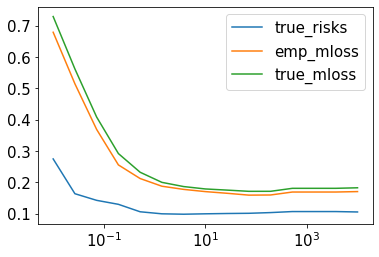

In [21]:
plt.plot(C_vals,true_risks, label='true_risks')
plt.plot(C_vals,emp_mloss, label='emp_mloss')
plt.plot(C_vals,true_mloss, label='true_mloss')

plt.xscale('log')
plt.legend()

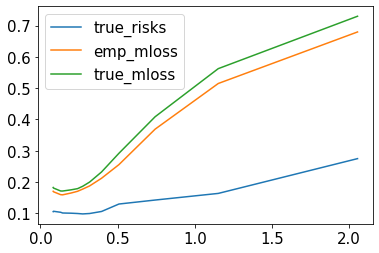

In [22]:
plt.plot(margins,true_risks, label='true_risks')
plt.plot(margins,emp_mloss, label='emp_mloss')
plt.plot(margins,true_mloss, label='true_mloss')

plt.legend()

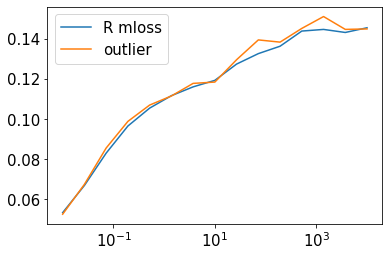

In [23]:
plt.plot(C_vals,rads, label='R mloss')
plt.plot(C_vals,outliers, label='outlier')

plt.xscale('log')
plt.legend()

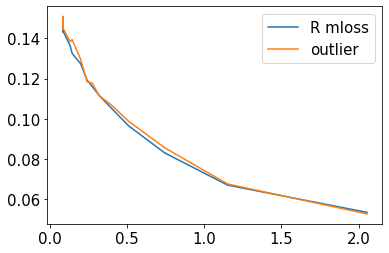

In [24]:
plt.plot(margins,rads, label='R mloss')
plt.plot(margins,outliers, label='outlier')

plt.legend()

### step 5: aggregate formulas

(1) True risk <

(2) true_mloss <

(3) emp_risk + outlier + sqrt(log(1/delta)/2m) <

(4) emp_risk + 2 * rad_mloss + sqrt(log(1/delta)/2m) <

(5) emp_risk + 2/rho * conf + sqrt(log(1/delta)/2m)

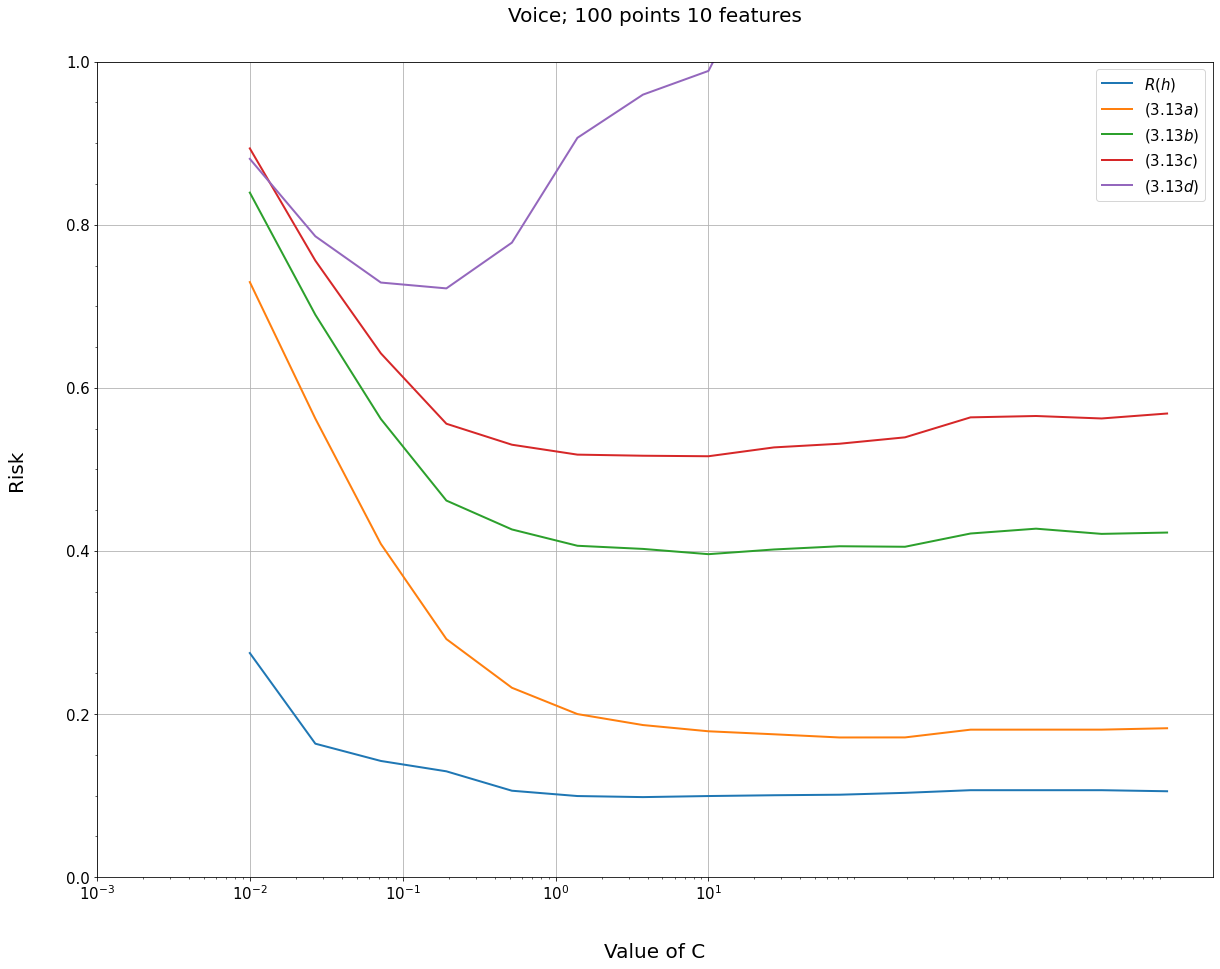

In [29]:
import matplotlib.cm as cm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

color_val = 0.2
cmain = cm.Oranges(color_val)
csub = cm.Blues(color_val)

delta = 0.1

f1 = true_risks
f2 = true_mloss
f3 = np.array(emp_mloss) + np.array(outliers) + np.sqrt(np.log(1/delta)/(2*m))
f4 = np.array(emp_mloss) + 2 * np.array(rads) + np.sqrt(np.log(1/delta)/(2*m))
f5 = np.array(emp_mloss) + (2 / np.array(margins)) * np.array(confs) + np.sqrt(np.log(1/delta)/(2*m))

plt.plot(C_vals, f1, lw=2, label=r'$R(h)$')
plt.plot(C_vals, f2, lw=2, label=r'$(3.13a)$')
plt.plot(C_vals, f3, lw=2, label=r'$(3.13b)$')
plt.plot(C_vals, f4, lw=2, label=r'$(3.13c)$')
plt.plot(C_vals, f5, lw=2, label=r'$(3.13d)$')


plt.ylim(0,1)
plt.xscale('log')

ax.minorticks_on()
ax.grid(True, which='major')

ax.xaxis.set_major_locator(MultipleLocator(0.5))

plt.xticks([1e-3, 1e-2, 1e-1, 1e-0, 10], fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Value of C", fontsize=20, labelpad=40)
plt.ylabel("Risk", fontsize=20, labelpad=40)
plt.title(r'Voice; 100 points 10 features', fontsize=20, pad=40)

plt.savefig("images/VoiceC.png", bbox_inches='tight')

plt.show()


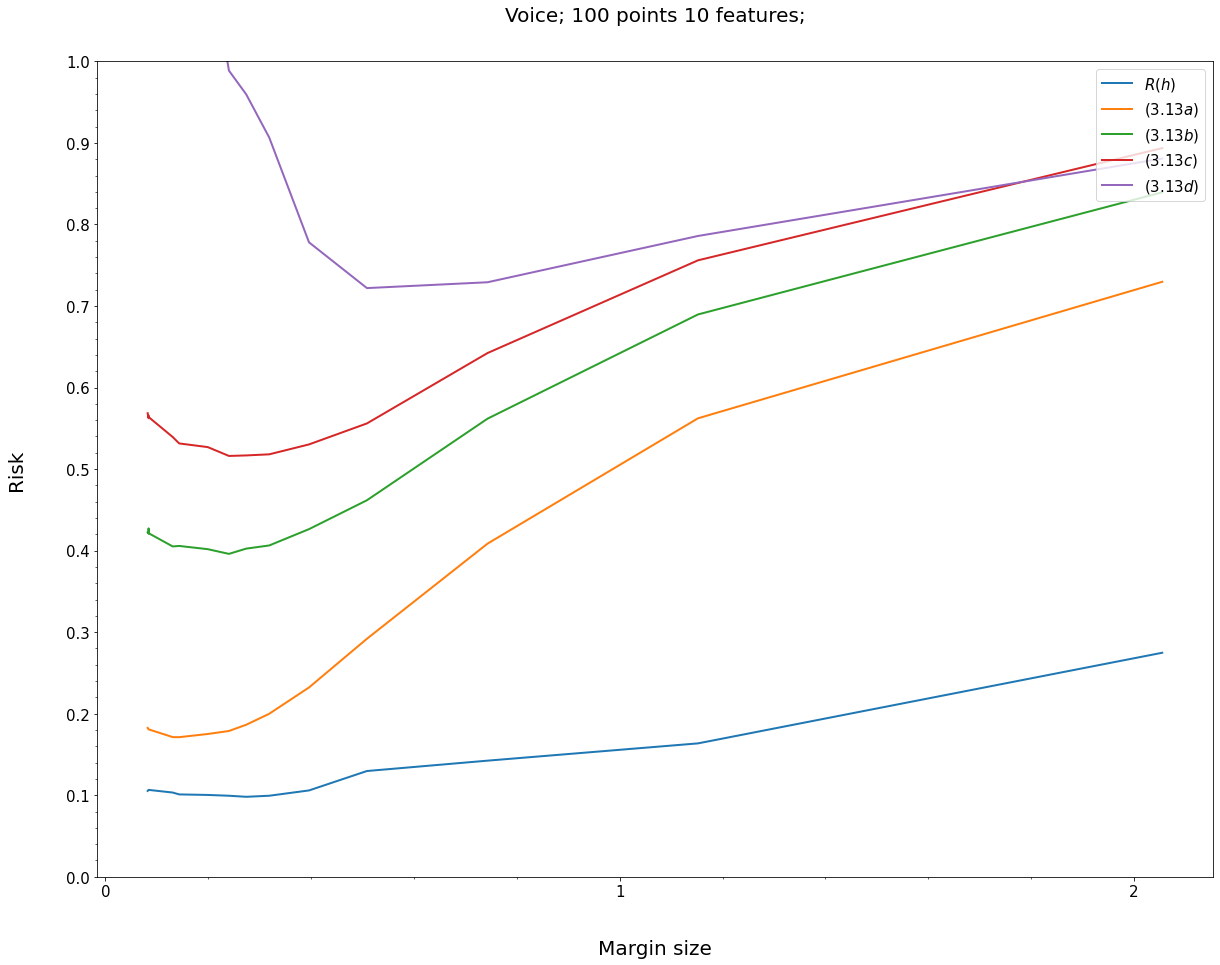

In [30]:
import matplotlib.cm as cm
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

color_val = 0.2
cmain = cm.Oranges(color_val)
csub = cm.Blues(color_val)

delta = 0.1

f1 = true_risks
f2 = true_mloss
f3 = np.array(emp_mloss) + np.array(outliers) + np.sqrt(np.log(1/delta)/(2*m))
f4 = np.array(emp_mloss) + 2 * np.array(rads) + np.sqrt(np.log(1/delta)/(2*m))
f5 = np.array(emp_mloss) + (2 / np.array(margins)) * np.array(confs) + np.sqrt(np.log(1/delta)/(2*m))

plt.plot(margins, f1, lw=2, label=r'$R(h)$')
plt.plot(margins, f2, lw=2, label=r'$(3.13a)$')
plt.plot(margins, f3, lw=2, label=r'$(3.13b)$')
plt.plot(margins, f4, lw=2, label=r'$(3.13c)$')
plt.plot(margins, f5, lw=2, label=r'$(3.13d)$')

plt.ylim(0,1)

ax.minorticks_on()
ax.grid(True, which='major')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.grid(which='major', color='#CCCCCC', linestyle='--')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Risk", fontsize=20, labelpad=40)
plt.title(r'Voice; 100 points 10 features;', fontsize=20, pad=40)

plt.savefig("images/VoiceM", bbox_inches='tight')

plt.show()
